In [116]:
import librosa
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import IPython
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
print("started.. ")
start_time = datetime.now()
data_path = 'recordings/'
audios = os.listdir(data_path)
audio_df = pd.DataFrame()
audio_df["path"] = audios
audio_df["label"] = [aud.split("_")[0] for aud in audios]
print("Done ...  Time taken : ",datetime.now()-start_time)
print("The Total files ", len(audios))
audio_df.head()

started.. 
Done ...  Time taken :  0:00:00.412177
The Total files  2000


,path,label
0,0_jackson_0.wav,0
1,0_jackson_1.wav,0
2,0_jackson_10.wav,0
3,0_jackson_11.wav,0
4,0_jackson_12.wav,0


### About
<pre>
Librosa loads the audio in one channel where it normalize all the data.
Refrences : 
    
</pre>

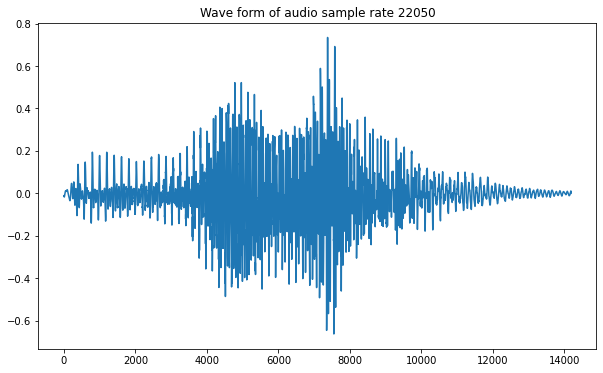

In [3]:
audio,sample_rate = librosa.load("recordings/0_jackson_0.wav")
plt.title("Wave form of audio sample rate 22050")
plt.plot(audio)
plt.show()

In [4]:
import IPython

IPython.display.Audio('recordings/0_jackson_0.wav')

## Train test split
<pre>
Train - 80 percent
Test - 20 percent
</pre>

In [5]:
 y_values = audio_df.label
x_values = audio_df.drop(columns=['label'])
x_train,x_test,y_train,y_test = train_test_split(x_values,y_values,train_size=0.8,shuffle=True,stratify=y_values)
print("The total size of data : ",audio_df.shape[0])
print("The test size is :",x_test.shape[0],", Lable : ",y_test.shape[0])
print("The train size is :",x_train.shape[0],", Label : ",y_train.shape[0])

The total size of data :  2000
The test size is : 400 , Lable :  400
The train size is : 1600 , Label :  1600


## Distribution of Data pre Classes

The distibutio of labels per classes in the train data 



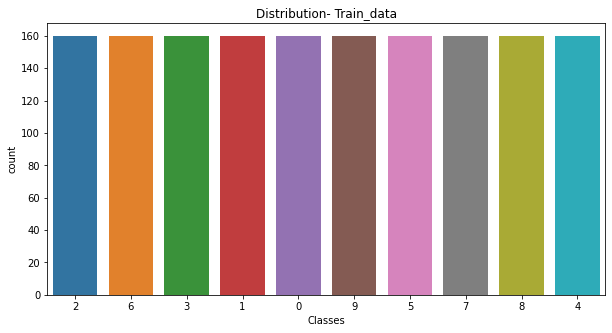


The distribution of label per classed in the test data : 



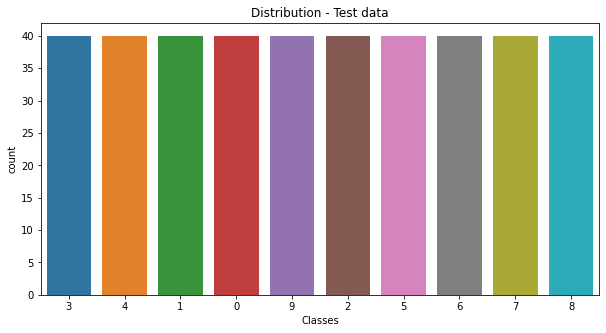

In [6]:
print("The distibutio of labels per classes in the train data ")
print()
x = y_train.values
plt.figure(figsize=(10,5))
plt.title("Distribution- Train_data")
sns.countplot(x=x)
plt.xlabel("Classes")
plt.show()
print()
print("The distribution of label per classed in the test data : ")
print()
x = y_test.values
plt.figure(figsize=(10,5))
plt.title("Distribution - Test data")
sns.countplot(x=x)
plt.xlabel("Classes")
plt.show()

### Observation 

<pre>
The data we are dealing is balanced over all the classes.
</pre>

## Explorative Data analyis

### Getting the optimal length 
<pre>
Since not all the audio loaded have the same length so finding the optimal shape. To feed the LSTM network

As librosa load the file in form of amplitude of the waveform at sample t.
Here, we take the sample rate of 22050 which means at time t 22050 instance of amplitude is loaded.

Source - <a href ="https://stackoverflow.com/questions/61986490/what-information-does-librosa-load-return"> https://stackoverflow.com/questions/61986490/what-information-does-librosa-load-return
</pre>

In [7]:
sample_rate = 22050
def get_sample_duration(x,get_duration=True): # might not need to check for other data
    sample,rate = librosa.load(x,sr=sample_rate)
    # duration is sample/sample_rate but we use funtion in librosa for accuracy 
    if get_duration:      
        dur = librosa.get_duration(y=sample,sr=rate)
        return sample,dur
    else:
        return sample
    


In [8]:
sample_train , duration_train, sample_test,duration_test = [],[],[],[]
print("Train Started ....")
start_time = datetime.now()

for audio in x_train.path:
    sample,duration = get_sample_duration("recordings/"+audio)
    sample_train.append(sample)
    duration_train.append(duration)
    
print("Train process completed ...")
print("")
print("Val started ...")
print("")

for audio in x_test.path:
    sample,duration = get_sample_duration("recordings/"+audio)
    sample_test.append(sample)
    duration_test.append(duration)
    
print("Done...")
print("Total time taken : ",datetime.now()-start_time)


Train Started ....
Train process completed ...

Val started ...

Done...
Total time taken :  0:02:16.344065


In [9]:
print("Lenght of sample_train : ", len(sample_train))

Lenght of sample_train :  1600


### Visualizing for optimal length

<pre>
- Distibution - distribution plot

</pre>

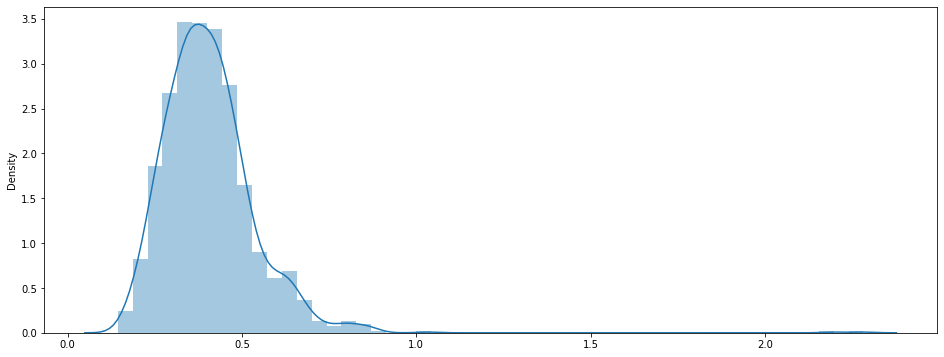

In [10]:
plt.figure(figsize=(16,6))
sns.distplot(x=duration_train)
plt.show()

### Box plot

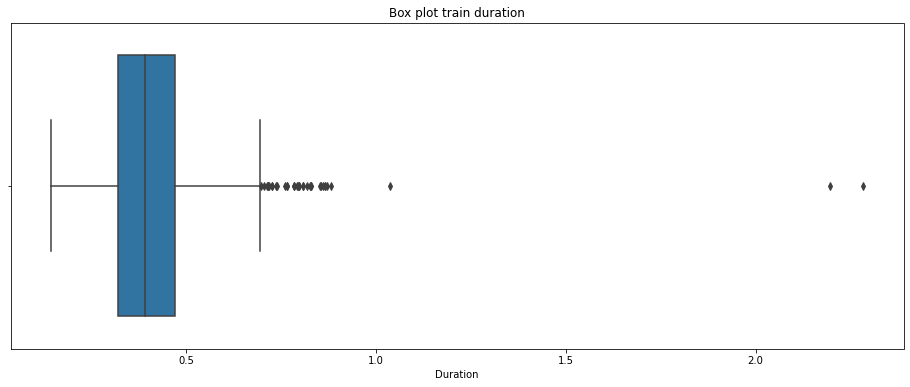

In [11]:
plt.figure(figsize=(16,6))
plt.title("Box plot train duration")
sns.boxplot(duration_train)
plt.xlabel("Duration")
plt.show()

### Observation
__From Box plot and Distplot__
<pre>

- Upper bound lies somewhere between 0.5 to 1.0. As seen there are some outlinear.
- Mean values lies between 0.5 to 0.2.
</pre>


### Percentile.

In [12]:
def cal_percentile(duration,start,end,step,more=False):
    print()
    print("*"*50)
    print("Percentile from {} to {} ".format(start,end),"with step {} .".format(step))
    print("*"*50)
    print()
    y = sorted(duration)
    length = len(y)
    
    if more==False:
        for i in range(start,end,step):
            print(i,"th percentile of data :", y[int((i/100)*(length-1))])
        
    if more:
        for i in np.arange(start,end,step):
           
            print(99+i,"th percentile of data :", y[int(((99+i)/100)*(length-1))])
            
      
   

In [13]:
cal_percentile(duration_train,0,110,10)
cal_percentile(duration_train,90,101,1)
cal_percentile(duration_train,0,1.1,0.1,more=True)


**************************************************
Percentile from 0 to 110  with step 10 .
**************************************************

0 th percentile of data : 0.1436281179138322
10 th percentile of data : 0.26090702947845806
20 th percentile of data : 0.30090702947845804
30 th percentile of data : 0.3340136054421769
40 th percentile of data : 0.36027210884353744
50 th percentile of data : 0.39102040816326533
60 th percentile of data : 0.4196371882086168
70 th percentile of data : 0.44988662131519275
80 th percentile of data : 0.48603174603174604
90 th percentile of data : 0.5619047619047619
100 th percentile of data : 2.282766439909297

**************************************************
Percentile from 90 to 101  with step 1 .
**************************************************

90 th percentile of data : 0.5619047619047619
91 th percentile of data : 0.5759183673469388
92 th percentile of data : 0.5895238095238096
93 th percentile of data : 0.6078911564625851
94 th percentil

### Observation

<pre>
Since 90 percent of the train data has duration of 0.8 sec so we limit duration to 0.8.
which gives total vector of 0.8 * 22050 = 17640 samples.

as librosa sample 22050 amplitude in 1 sec.

<b>Therefore</b>

If the sample vector has the length less than  17640 we pad the sequence else we trunctate it.
</pre>

### Padding the Sequence

<pre>
For padding use dtype=x.dtype or dtype="float32" otherwise it will give all the values zeros if your values are in range of 0-1.
</pre>

In [14]:
max_length = 17640
# for train data
train_x = pad_sequences(sample_train,maxlen=max_length,dtype="float32")
# for test data
test_x = pad_sequences(sample_test,maxlen=max_length,dtype="float32")
print("The train data after padding :",train_x.shape)
print("The test data after padding : ",test_x.shape)

The train data after padding : (1600, 17640)
The test data after padding :  (400, 17640)


### Model 1
<pre>
<b><u>Giving whole row directly.</u></b>

Lstm input shape = [batch_size,timestamp,col]
    timestamp = length of single row.
here,
    timestamp = 17640
    batch_size = 1600
    col = 1
    
    
<font color="red">Note</font>

    For the sparse_categorical_crossentropy we no need to change the ylabel to categorical.
    but if the loss is only categorical_crossentropy then y label must be changed to categorical order.
</pre>

In [51]:
print("Changing in the input form required by LSTM : ")
print()
X_train_seq = np.expand_dims(train_x,-1)
X_test_seq  = np.expand_dims(test_x,-1)
print("After changing x_train shape ",X_train_seq.shape)
print("After changing x_test shape ",X_test_seq.shape)

loss_sparse = False

if loss_sparse:
    print()
    print("Changing labels to categorical ")
    y_train_cat = []
    y_train_y = []
    for i in y_train.values:
        y_train_y.append(int(i))    
    y_train_cat = np.array(y_train_y)
else:
    print()
    print("Changing labels to categorical ")
    y_train_cat = to_categorical(y_train.values)
    y_test_cat = to_categorical(y_test.values)
    print()
    
print("After changing : ")
print("Y train categorical shape : ",y_train_cat.shape)
print("Y Test categorical shape : ",y_test_cat.shape)

Changing in the input form required by LSTM : 

After changing x_train shape  (1600, 17640, 1)
After changing x_test shape  (400, 17640, 1)

Changing labels to categorical 

After changing : 
Y train categorical shape :  (1600, 10)
Y Test categorical shape :  (400, 10)


### Building the model

In [285]:
tf.keras.backend.clear_session()
timestamp = X_train_seq.shape[1]
col = X_train_seq.shape[2]
inputs = tf.keras.layers.Input((timestamp,col))
x = LSTM(25,activation="relu")(inputs)
x = Dense(50,activation="relu")(x)
out = Dense(10,activation="softmax")(x)
model1 = Model(inputs=inputs,outputs=out)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17640, 1)]        0         
                                                                 
 lstm (LSTM)                 (None, 25)                2700      
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 4,510
Trainable params: 4,510
Non-trainable params: 0
_________________________________________________________________


In [298]:
model1.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy',metrics=["accuracy"])
model1.fit(X_train_seq,y_train_cat,batch_size=8,epochs=1)

200/200 [==============================] - 1705s 9s/step - loss: 2.3030 - accuracy: 0.0962


In [313]:
model1.history.history

{'loss': [2.3030388355255127], 'accuracy': [0.09624999761581421]}

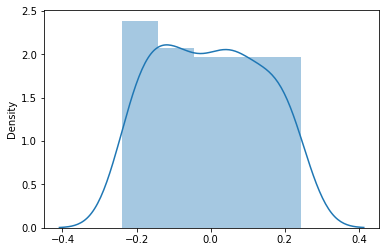

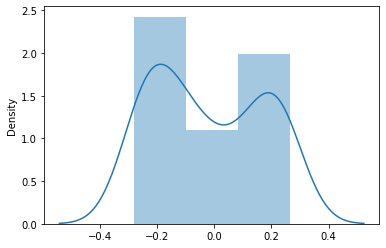

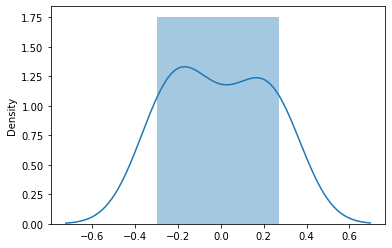

In [346]:
for layers in model1.layers[1:]:
    weights = layers.weights
    sns.distplot(weights[0][0])
    plt.show()
    

### Observation
<pre>
Model seem to perform worse as accuracy is close to 10%. 

So featuring the data is necessary. 
For featuring using <b>Spectogram</b>.
Where, 

Spectogram shows the intensity of sound along time axis. 
</pre>

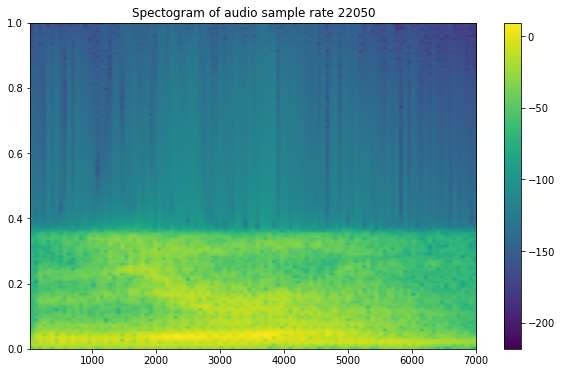

In [31]:
file_name = "recordings/0_jackson_0.wav"
audio,sample_rate = librosa.load(file_name)
plt.title("Spectogram of audio sample rate 22050")
# plt.plot(audio)
plt.specgram(audio)
plt.colorbar()
plt.show()
IPython.display.Audio(file_name)

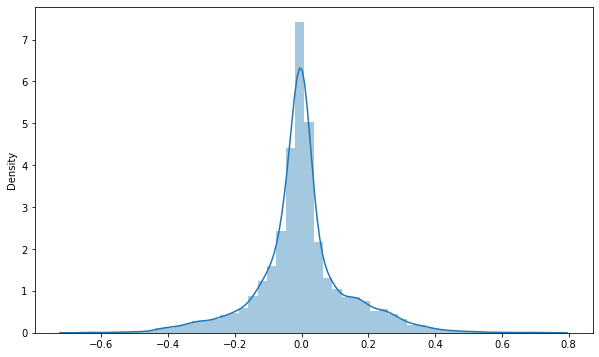

In [34]:
sns.distplot(audio)
plt.show()

### Observation
<pre>
Thus we can see for this audio pitch lies in the range of 0- 0.4



Spectogram:

sourse : https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
</pre>

In [46]:
def convert_to_spectrogram(raw_data):
    
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [47]:
print("Start")
start_time = datetime.now()
print("Train spectogram")

X_train_spectrogram = []
for ele in train_x:
    logmel = convert_to_spectrogram(ele)
    X_train_spectrogram.append(logmel)
X_train_spectrogram = np.array(X_train_spectrogram)
print("Time taken to process the train spec ",datetime.now()-start_time)
start_time = datetime.now()
print()

print("Test spectogram")
X_test_spectrogram = []
for ele in test_x:
    logmel = convert_to_spectrogram(ele)
    X_test_spectrogram.append(logmel)
X_test_spectrogram = np.array(X_test_spectrogram)
print("Time taken to process the test spec ",datetime.now()-start_time)

Start
Train spectogram
Time taken to process the train spec  0:00:12.340416

Test spectogram
Time taken to process the test spec  0:00:03.546053


### Using mean after the layers

In [48]:
tf.keras.backend.clear_session()
inp = Input(shape = (64,35,))
x = LSTM(256, return_sequences = True)(inp)
x = tf.math.reduce_mean(x, axis = -1)
x = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model2 = Model(inputs = inp, outputs = out)
#printing the model summary
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 256)           299008    
                                                                 
 tf.math.reduce_mean (TFOpLa  (None, 64)               0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 318,218
Trainable params: 318,218
Non-trainable params: 0
_______________________________________________________

In [53]:
model2.compile(optimizer = tf.keras.optimizers.Adam(0.0005), loss = 'categorical_crossentropy',metrics=["accuracy"])

model2.fit(X_train_spectrogram, y_train_cat, validation_data = (X_test_spectrogram, y_test_cat),
           batch_size = 16, epochs = 15)

Epoch 1/15
100/100 [==============================] - 19s 147ms/step - loss: 1.4815 - accuracy: 0.4925 - val_loss: 1.4342 - val_accuracy: 0.5125
Epoch 2/15
100/100 [==============================] - 14s 134ms/step - loss: 1.2666 - accuracy: 0.5769 - val_loss: 1.1474 - val_accuracy: 0.6100
Epoch 3/15
100/100 [==============================] - 14s 135ms/step - loss: 1.0593 - accuracy: 0.6538 - val_loss: 1.0077 - val_accuracy: 0.6525
Epoch 4/15
100/100 [==============================] - 13s 134ms/step - loss: 0.9385 - accuracy: 0.7069 - val_loss: 0.8869 - val_accuracy: 0.6975
Epoch 5/15
100/100 [==============================] - 14s 135ms/step - loss: 0.8248 - accuracy: 0.7275 - val_loss: 0.8121 - val_accuracy: 0.7025
Epoch 6/15
100/100 [==============================] - 13s 129ms/step - loss: 0.7555 - accuracy: 0.7538 - val_loss: 0.7964 - val_accuracy: 0.7350
Epoch 7/15
100/100 [==============================] - 13s 130ms/step - loss: 0.7015 - accuracy: 0.7675 - val_loss: 0.7092 - val_ac

### Using Flatten in the layer

In [56]:
tf.keras.backend.clear_session()
inp = Input(shape = (64,35,))
x = LSTM(256, return_sequences = True)(inp)
x = tf.keras.layers.Flatten()(x)
x = Dense(256, activation = 'relu', kernel_initializer = 'he_normal')(x)
out = Dense(10, activation = 'softmax', kernel_initializer = 'glorot_normal')(x)

model3 = Model(inputs = inp, outputs = out)
#printing the model summary
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 35)]          0         
                                                                 
 lstm (LSTM)                 (None, 64, 256)           299008    
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 4,496,138
Trainable params: 4,496,138
Non-trainable params: 0
_________________________________________________________________


In [57]:
model3.compile(optimizer = tf.keras.optimizers.Adam(0.0005), loss = 'categorical_crossentropy',metrics=["accuracy"])

model3.fit(X_train_spectrogram, y_train_cat, validation_data = (X_test_spectrogram, y_test_cat),
           batch_size = 16, epochs = 15)

Epoch 1/15
100/100 [==============================] - 22s 166ms/step - loss: 1.4132 - accuracy: 0.5356 - val_loss: 0.6296 - val_accuracy: 0.8075
Epoch 2/15
100/100 [==============================] - 15s 146ms/step - loss: 0.5233 - accuracy: 0.8238 - val_loss: 0.3719 - val_accuracy: 0.9000
Epoch 3/15
100/100 [==============================] - 15s 147ms/step - loss: 0.3034 - accuracy: 0.9013 - val_loss: 0.2405 - val_accuracy: 0.9375
Epoch 4/15
100/100 [==============================] - 15s 147ms/step - loss: 0.2260 - accuracy: 0.9331 - val_loss: 0.1874 - val_accuracy: 0.9500
Epoch 5/15
100/100 [==============================] - 14s 143ms/step - loss: 0.1809 - accuracy: 0.9456 - val_loss: 0.1953 - val_accuracy: 0.9525
Epoch 6/15
100/100 [==============================] - 14s 144ms/step - loss: 0.1525 - accuracy: 0.9538 - val_loss: 0.1747 - val_accuracy: 0.9500
Epoch 7/15
100/100 [==============================] - 14s 138ms/step - loss: 0.1120 - accuracy: 0.9675 - val_loss: 0.1389 - val_ac

## Plot

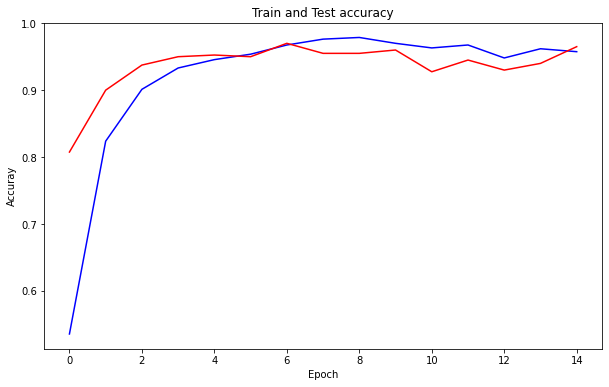

In [63]:
train_acc = model3.history.history["accuracy"]
test_acc = model3.history.history["val_accuracy"]
plt.title("Train and Test accuracy")
plt.plot(train_acc,c="blue")
plt.plot(test_acc,c="red")
plt.xlabel("Epoch")
plt.ylabel("Accuray")
plt.show()

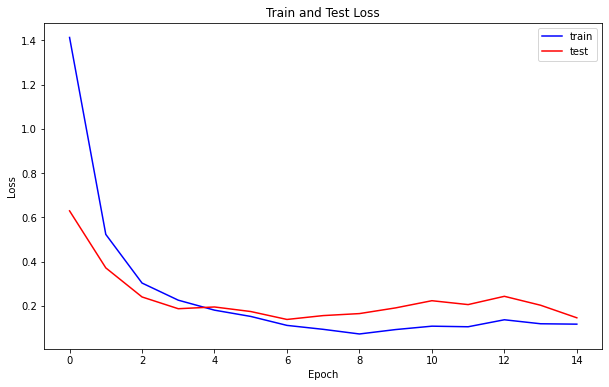

In [68]:
train_loss = model3.history.history["loss"]
test_loss = model3.history.history["val_loss"]
plt.title("Train and Test Loss")
plt.plot(train_loss,c="blue")
plt.plot(test_loss,c="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","test"])
plt.show()

In [86]:
model3.save("bestmodel3.h5")

In [ ]:
model_pred = tf.keras.models.load_model("bestmodel3.h5")

In [112]:
def predict(file_name):
    x, s = librosa.load(file_name,sr=22050)
    x = pad_sequences([x],maxlen=max_length,dtype="float32")
    x = convert_to_spectrogram(x)
    pred = model_pred.predict(x)
    pred = np.argmax(pred)
    
    return pred


In [113]:
predicted = []
for song in tqdm(x_test.path):
    pred = predict("recordings/"+song)
    predicted.append(pred)
    
# predicted
    

100%|██████████| 400/400 [01:20<00:00,  4.95it/s]


[3,
 3,
 3,
 4,
 1,
 2,
 1,
 9,
 3,
 2,
 3,
 5,
 6,
 6,
 2,
 6,
 7,
 9,
 5,
 9,
 6,
 8,
 2,
 1,
 1,
 0,
 6,
 6,
 4,
 7,
 4,
 7,
 2,
 1,
 4,
 7,
 0,
 4,
 4,
 0,
 1,
 9,
 9,
 0,
 7,
 0,
 1,
 4,
 6,
 6,
 7,
 0,
 9,
 8,
 2,
 8,
 2,
 5,
 0,
 4,
 3,
 0,
 9,
 8,
 1,
 7,
 1,
 6,
 6,
 1,
 4,
 1,
 2,
 2,
 2,
 6,
 1,
 7,
 7,
 4,
 1,
 6,
 4,
 2,
 5,
 9,
 9,
 6,
 4,
 4,
 4,
 3,
 1,
 5,
 5,
 9,
 2,
 6,
 7,
 1,
 4,
 8,
 6,
 3,
 8,
 9,
 8,
 3,
 9,
 8,
 5,
 0,
 6,
 0,
 4,
 3,
 3,
 6,
 1,
 8,
 9,
 2,
 0,
 4,
 3,
 9,
 1,
 0,
 4,
 3,
 3,
 9,
 6,
 7,
 6,
 6,
 0,
 6,
 3,
 7,
 6,
 2,
 7,
 9,
 2,
 2,
 3,
 0,
 3,
 1,
 8,
 5,
 6,
 8,
 0,
 4,
 5,
 9,
 5,
 2,
 5,
 7,
 3,
 3,
 8,
 5,
 8,
 1,
 3,
 9,
 2,
 9,
 1,
 0,
 7,
 2,
 0,
 5,
 5,
 0,
 7,
 9,
 0,
 8,
 1,
 2,
 0,
 8,
 8,
 8,
 0,
 3,
 3,
 2,
 7,
 0,
 5,
 7,
 2,
 8,
 7,
 2,
 8,
 8,
 5,
 6,
 0,
 1,
 3,
 5,
 1,
 3,
 4,
 5,
 9,
 5,
 7,
 1,
 8,
 7,
 1,
 0,
 9,
 7,
 8,
 5,
 3,
 1,
 0,
 6,
 1,
 7,
 1,
 7,
 2,
 3,
 8,
 2,
 4,
 4,
 2,
 7,
 5,
 9,
 5,
 3,
 7,
 0,
 5,
 1,


In [128]:
pred_file = "record.wav"
predict(pred_file)

7

In [115]:
real_label = np.argmax(y_test_cat,axis=1)
len(real_label)

400

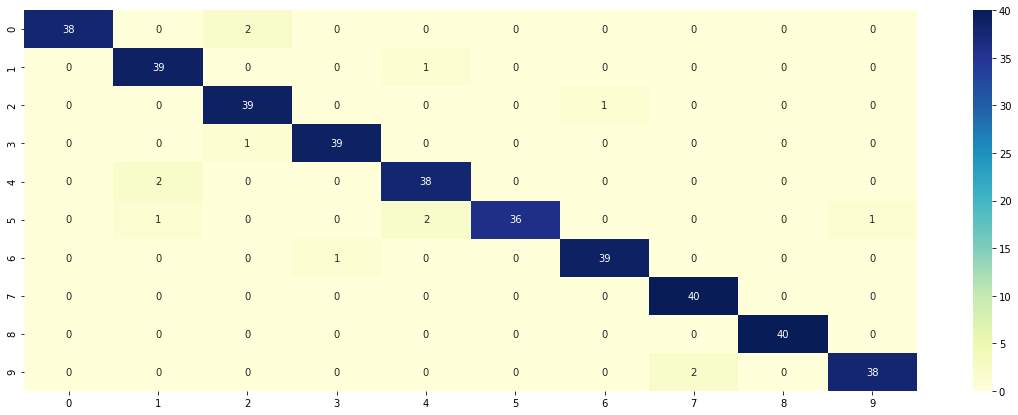

In [123]:
s = confusion_matrix(real_label,predicted)
plt.figure(figsize=(20,7))
sns.heatmap(s,annot=True,cmap="YlGnBu")
plt.show()